In [1]:
import os
import sys
import pandas as pd
from pathlib import Path
from datetime import datetime
from model_settings import ms
notebook_dir = str(Path().resolve())

from historical_av_underlying_fetcher import spots, symbol


pricing settings:
Actual/365 (Fixed) day counter
New York stock exchange calendar
compounding: continuous
frequency: annual

                            contract_key               raw_data_key  \
0     /date_2024_10_11/hottest_contracts  /date_2024_10_11/raw_data   
1     /date_2024_10_10/hottest_contracts  /date_2024_10_10/raw_data   
2     /date_2024_10_09/hottest_contracts  /date_2024_10_09/raw_data   
3     /date_2024_10_08/hottest_contracts  /date_2024_10_08/raw_data   
4     /date_2024_10_07/hottest_contracts  /date_2024_10_07/raw_data   
...                                  ...                        ...   
1045  /date_2020_08_17/hottest_contracts  /date_2020_08_17/raw_data   
1046  /date_2020_08_14/hottest_contracts  /date_2020_08_14/raw_data   
1047  /date_2020_08_13/hottest_contracts  /date_2020_08_13/raw_data   
1048  /date_2020_08_12/hottest_contracts  /date_2020_08_12/raw_data   
1049  /date_2020_08_11/hottest_contracts  /date_2020_08_11/raw_data   

                   su

In [9]:
dates = spots.index
dates = dates[:3]
for date in dates:
    print(date)

2020-08-10
2020-08-07
2020-08-06


In [10]:
from historical_alphaVantage_collection import collect_av_link
chain = {}
for date in dates:
    spot = float(spots[date])
    link = collect_av_link(date)
    printdate = datetime.strptime(date, '%Y-%m-%d').strftime('%A, %Y-%m-%d')
    chain[date] = link

In [11]:
print(type(chain))
for key in chain.keys():
    print(key)

<class 'dict'>
2020-08-10
2020-08-07
2020-08-06


In [12]:
contracts = []
for key,link in chain.items():
    contracts.append(link['raw_data'])
contracts = pd.concat(contracts,ignore_index=True)
contracts

,contractID,symbol,expiration,strike,type,last,mark,bid,bid_size,ask,ask_size,volume,open_interest,date,implied_volatility,delta,gamma,theta,vega,rho
0,SPY200810C00160000,SPY,2020-08-10,160.00,call,0.00,175.31,175.06,51,175.56,74,0,0,2020-08-10,4.19867,1.00000,0.00000,-0.00160,0.00000,0.00438
1,SPY200810P00160000,SPY,2020-08-10,160.00,put,0.00,0.01,0.00,0,0.01,4701,0,211,2020-08-10,4.42628,-0.00046,0.00002,-0.23434,0.00029,-0.00000
2,SPY200810C00165000,SPY,2020-08-10,165.00,call,0.00,170.31,170.06,51,170.56,74,0,0,2020-08-10,4.07910,1.00000,0.00000,-0.00165,0.00000,0.00452
3,SPY200810P00165000,SPY,2020-08-10,165.00,put,0.00,0.01,0.00,0,0.01,4790,0,23,2020-08-10,4.25113,-0.00048,0.00002,-0.23353,0.00030,-0.00000
4,SPY200810C00170000,SPY,2020-08-10,170.00,call,0.00,165.30,165.04,74,165.55,51,0,0,2020-08-10,3.95953,1.00000,0.00000,-0.00170,0.00000,0.00466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27237,SPY221216P00515000,SPY,2022-12-16,515.00,put,201.42,189.66,188.59,16,190.72,50,0,0,2020-08-06,0.24849,-0.82492,0.00202,-0.06504,1.32480,-10.99244
27238,SPY221216C00520000,SPY,2022-12-16,520.00,call,1.30,1.44,1.25,10000,1.63,3252,0,241,2020-08-06,0.15870,0.04653,0.00119,-0.01695,0.50027,0.33346
27239,SPY221216P00520000,SPY,2022-12-16,520.00,put,207.50,194.50,193.43,16,195.58,50,0,2,2020-08-06,0.25092,-0.82806,0.00198,-0.06486,1.30963,-11.13169
27240,SPY221216C00525000,SPY,2022-12-16,525.00,call,1.42,1.32,1.21,10,1.43,8,65,3469,2020-08-06,0.15901,0.04318,0.00112,-0.01599,0.47104,0.30972


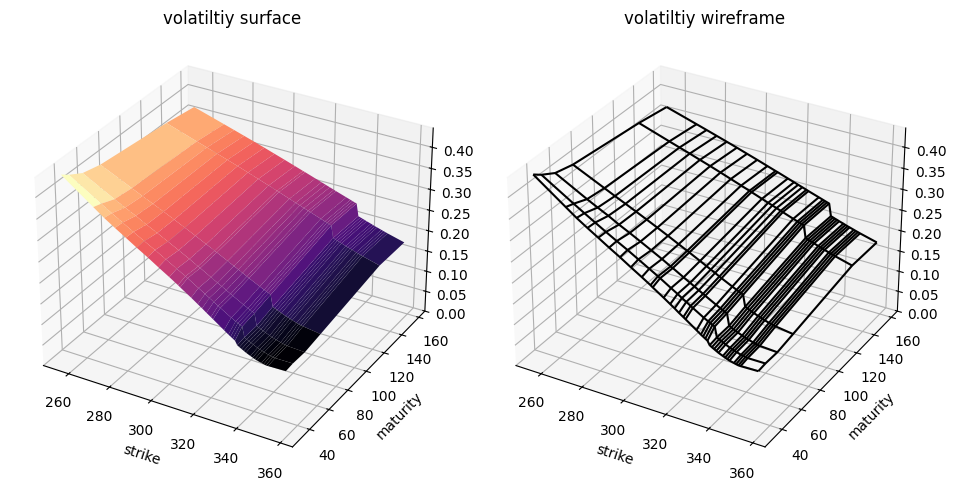

<Figure size 640x480 with 0 Axes>

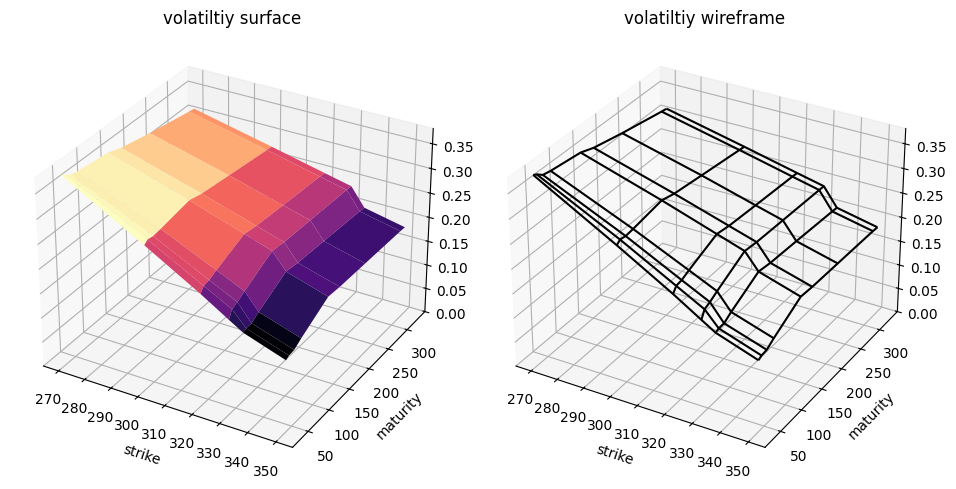

<Figure size 640x480 with 0 Axes>

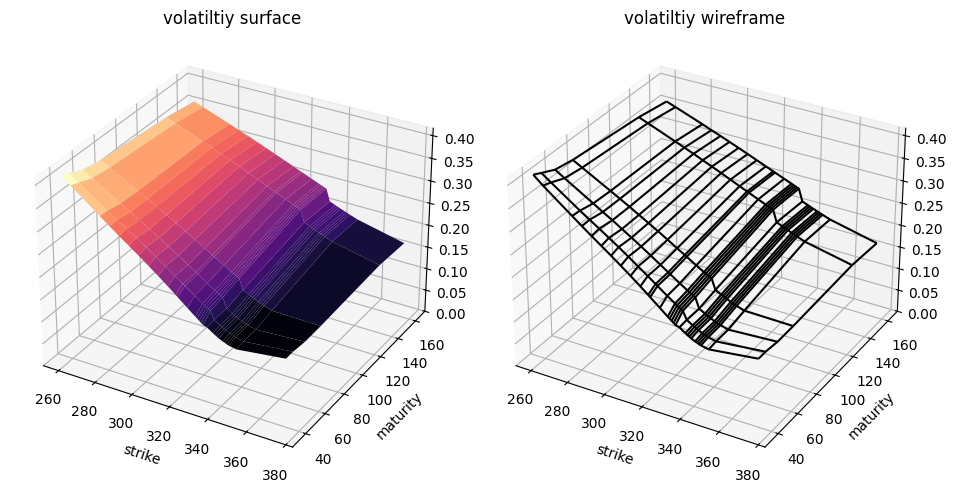

<Figure size 640x480 with 0 Axes>

In [13]:
from historical_av_plot_vol_surface import plot_vol_surface
for key,link in chain.items():
    plot_vol_surface(link['surface'])